In [1]:
import os

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import pandas as pd
import numpy as np

# Error rates

In [69]:
err_stats = {}
for folder in os.listdir(".."):
    if folder.startswith("report_"):
        ttype = folder.split("_")[1]

        files = os.listdir("../"+folder)
        success = [x for x in files if x.endswith("json")]
        err = [x for x in files if x.endswith("err")]
        
        err_stats[ttype] = [len(success), len(err)]

df = pd.DataFrame(err_stats, index=["success", "errors"])
df.sort_values("success", axis=1, ascending=False, inplace=True)
df

,clean,trojan,dropper,backdoor,ransomware,rat,coinminer,keylogger
success,25291,12780,11150,11062,9627,9479,6893,4574
errors,569,347,124,26,386,57,2971,3034


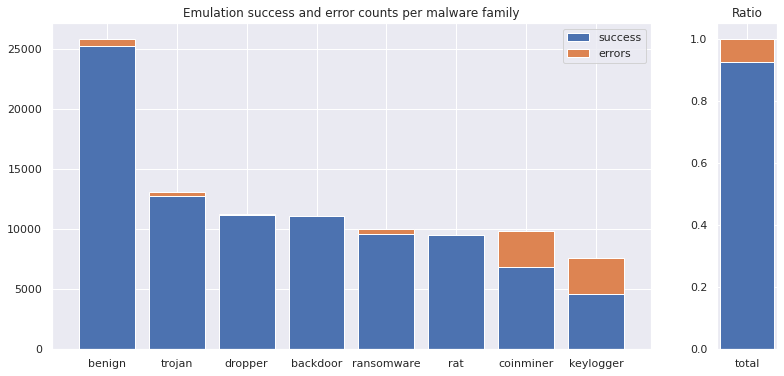

In [195]:
fig, ax = plt.subplots(1, 2, gridspec_kw={"width_ratios": [10,1]}, figsize=(13, 6))

success = df.loc["success"]
errors = df.loc["errors"]

ax[0].bar(x=["benign"]+ success.index[1:].tolist(), height=success.values)
ax[0].bar(x=["benign"]+ errors.index[1:].tolist(), height=errors.values, bottom=success.values)
ax[0].set_title("Emulation success and error counts per malware family", fontsize=12)
ax[0].legend(["success", "errors"])

total = df.sum(axis=1)
success_percentage = total["success"]/total.sum()
error_percentage = total["errors"]/total.sum()

ax[1].bar(x="total", height=success_percentage, width=0.4)
ax[1].bar(x="total", height=error_percentage, bottom=success_percentage, width=0.4)
_ = ax[1].set_title("Ratio", fontsize=12)
#ax[1].yaxis.set_label_position("right")
#ax[1].yaxis.tick_right()

In [21]:
# grep -r emulation_logs/ -ie "Err" | cut -d" " -f6- | sed 's/PeX86Exe.*$//' | sed 's/args.*$//'| sed 's/0x[a-f0-9]*//' > errors.lst
with open("errors.lst") as f:
    data = f.readlines()
data = [x.replace("[-]","").strip() for x in data if "ordinal_100" not in x.lower() and len(x.strip()) > 0]

In [22]:
from collections import Counter
c = Counter(data)

In [36]:
c.most_common(15)

[("[DBG]: API nr.: 0; Err: ['invalid_read']; APIs:", 5051),
 ('Failed emulation, UcError: /data/quo.vadis/data/pe.dataset/', 3720),
 ('Failed emulation, NotSupportedError: /data/quo.vadis/data/pe.dataset/',
  724),
 ("['', '']; APIs:", 446),
 ("[DBG]: API nr.: 0; Err: ['Invalid memory write (UC_ERR_WRITE_UNMAPPED)']; APIs:",
  220),
 ('APIs:', 205),
 ("API nr.: 0; Err: ['invalid_read']; APIs:", 173),
 ('UcError(status)', 108),
 ("[DBG]: API nr.: 0; Err: ['Invalid memory read (UC_ERR_READ_UNMAPPED)']; APIs:",
  103),
 ("[DBG]: API nr.: 0; Err: ['', '']; APIs:", 91),
 ('./errors.lst:UcError(status)', 73),
 ('./errors.lst:./errors.lst:UcError(status)', 73),
 ("['invalid_read']; APIs:", 71),
 ("[DBG]: API nr.: 0; Err: ['Invalid instruction (UC_ERR_INSN_INVALID)']; APIs:",
  68),
 ("API nr.: 0; Err: ['', '']; APIs:", 66)]

In [32]:
weird = c.most_common(10)[3][0] # empty error from Speakeasy
[x for x in data if weird in x][0:5]

["[DBG]: API nr.: 0; Err: ['', '']; APIs:",
 "[DBG]: API nr.: 0; Err: ['', '']; APIs:",
 "[DBG]: API nr.: 0; Err: ['', '']; APIs:",
 "[DBG]: API nr.: 0; Err: ['', '']; APIs:",
 "[DBG]: API nr.: 0; Err: ['', '']; APIs:"]

# Distinct API counts

In [2]:
import sys
sys.path.append("../../../modules/morbus.certatio")
from preprocessing.reports import report_to_apiseq
from utils.functions import flatten

In [3]:
report_apiseqlist = []
for folder in os.listdir(".."):
    if folder.startswith("report_"):
        print("\n",folder)
        files = os.listdir("../"+folder)
        reports = [x for x in files if x.endswith("json")]
        for i,report in enumerate(reports):
            print(f"{i}/{len(reports)}", end="\r")
            report_apiseqlist.append(report_to_apiseq("../"+folder+"/"+report))
            
df = pd.DataFrame(report_apiseqlist)
del report_apiseqlist
df.head()


 report_backdoor
11061/11062
 report_rat
9478/9479
 report_trojan
12779/12780
 report_dropper
11149/11150
 report_ransomware
9626/9627
 report_clean
25290/25291
 report_keylogger
4573/4574
 report_coinminer


,sha256,api.seq,api.seq.len
0,f4ef0148f6c6967795260d9b8ac5653d5d4edf9cb7e2bd...,"[kernel32.virtualalloc, kernel32.virtualfree, ...",450
1,63897bc95bc304fd273fbf5faf1eac08c7673e96690d25...,"[kernel32.loadlibrarya, kernel32.getprocaddres...",147
2,f60c15662e4dc06d9176f9e9bdb1601a82a65895cc601c...,"[crtdll.__getmainargs, kernel32.getcommandline...",501
3,63b143e1ec7341901adea6e760c8df8eec7738d23c4987...,"[kernel32.getversion, kernel32.heapcreate, ker...",54
4,cd28406050c2c8868f423f1600ae051da59e1d3f6222b0...,"[kernel32.getsystemtimeasfiletime, kernel32.ge...",451


In [58]:
from collections import Counter
apicounts = Counter(flatten(df["api.seq"].values))
values = [x[1] for x in apicounts.most_common()]

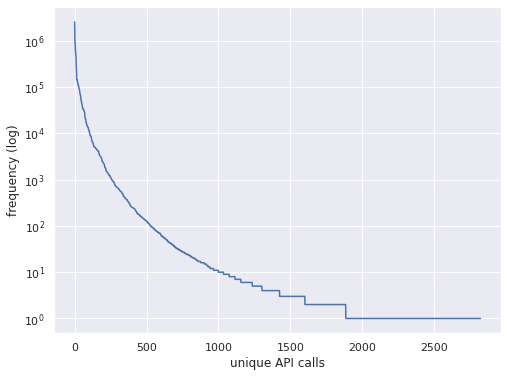

In [63]:
plt.figure(figsize=(8,6))
plt.plot(values)
plt.ylabel("frequency (log)")
plt.xlabel("unique API calls")
# plt.xlim([0,1500])
_ = plt.yscale("log")

In [10]:
len(apicounts)

2822

In [56]:
def get_portion(counter, threshold):
    included_api_count = np.sum([x[1] for x in counter.most_common(threshold)])
    total_count = np.sum(list(counter.values()))
    return included_api_count, included_api_count/total_count

print(f"Top i API calls represent following portion of all calls:")
for i in [50, 100, 150, 200, 250, 300, 350]:
    ratio = get_portion(apicounts, i)[1]
    print(f"\t{i} : {ratio:.4f}")

Top i API calls represent following portion of all calls:
	50 : 0.8826
	100 : 0.9553
	150 : 0.9767
	200 : 0.9873
	250 : 0.9922
	300 : 0.9948
	350 : 0.9964


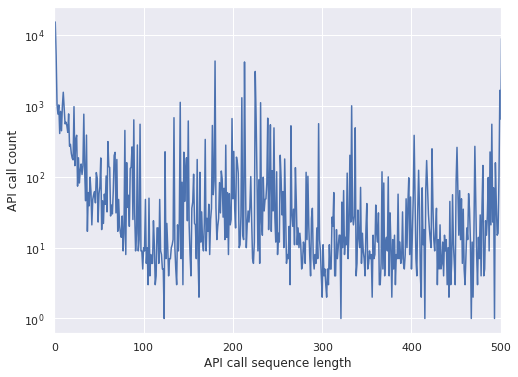

In [8]:
lengths = df["api.seq.len"].value_counts().sort_index()

plt.figure(figsize=(8,6))
plt.plot(lengths.index.tolist(), lengths.values.tolist())
plt.xlim([0,500])
plt.ylabel("API call count")
plt.xlabel("API call sequence length")
_ = plt.yscale("log")

## before lowercasing API calls

In [18]:
apicounts.most_common(15)

[('KERNEL32.IsBadReadPtr', 1882840),
 ('KERNEL32.GetProcAddress', 1411974),
 ('kernel32.GetProcAddress', 1124820),
 ('KERNEL32.TlsGetValue', 921323),
 ('kernel32.InitializeCriticalSectionEx', 921128),
 ('kernel32.FlsGetValue', 718375),
 ('KERNEL32.HeapAlloc', 623190),
 ('KERNEL32.LeaveCriticalSection', 524930),
 ('KERNEL32.EnterCriticalSection', 517219),
 ('KERNEL32.GetLastError', 453461),
 ('KERNEL32.SetLastError', 434243),
 ('KERNEL32.InitializeCriticalSectionAndSpinCount', 233843),
 ('KERNEL32.EncodePointer', 231391),
 ('kernel32.EncodePointer', 220916),
 ('KERNEL32.MultiByteToWideChar', 198188)]

## after lowercasing API calls

In [6]:
apicounts.most_common(15)

[('kernel32.getprocaddress', 2536899),
 ('kernel32.isbadreadptr', 1891588),
 ('kernel32.tlsgetvalue', 987392),
 ('kernel32.initializecriticalsectionex', 936742),
 ('kernel32.flsgetvalue', 718695),
 ('kernel32.heapalloc', 667898),
 ('kernel32.leavecriticalsection', 569049),
 ('kernel32.entercriticalsection', 562499),
 ('kernel32.getlasterror', 487061),
 ('kernel32.setlasterror', 464498),
 ('kernel32.encodepointer', 452307),
 ('kernel32.initializecriticalsectionandspincount', 278600),
 ('kernel32.decodepointer', 251797),
 ('kernel32.multibytetowidechar', 213518),
 ('kernel32.getcpinfoexw', 143376)]

Text(0.5, 0, 'API calls')

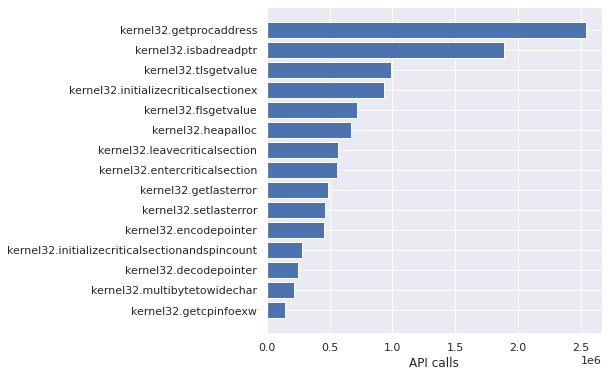

In [52]:
plt.figure(figsize=(6,6))
plt.barh(y = [x[0] for x in apicounts.most_common(15)][::-1], width=[x[1] for x in apicounts.most_common(15)][::-1])
plt.xlabel("API calls")